# Experiments

In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from tqdm import tqdm
import time 
rng = np.random.default_rng()

In [2]:
# utility functions
normalize = lambda x, dim=-1: x /np.sum(x, axis=dim)

## 1D Case : Gaussians 


In [3]:
means = [1., 5., 10.]
stds = [.5, .2, .8] # rng.random(3) + .05
t = np.linspace(-5, 15, 100)

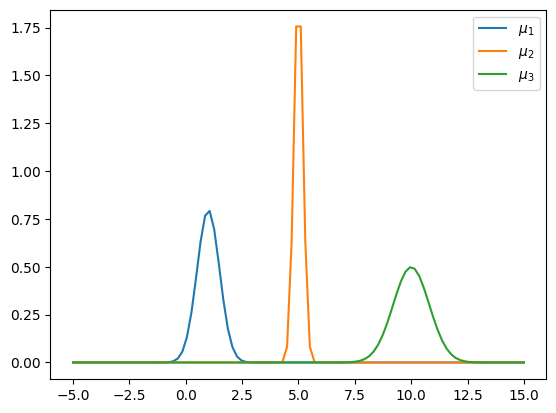

In [4]:
fig = plt.figure()

plt.plot(t, norm.pdf(t, loc=means[0], scale=stds[0]), label='$\mu_1$')
plt.plot(t, norm.pdf(t, loc=means[1], scale=stds[1]), label='$\mu_2$')
plt.plot(t, norm.pdf(t, loc=means[2], scale=stds[2]), label='$\mu_3$')

plt.legend()
plt.show()

### Method on a fixed grid 

In [5]:
# fixed grid 
M = 500
x = np.linspace(-5, 15, M)

**Method 1 :** Compute the barycenter on a refined grid using the cumulative function

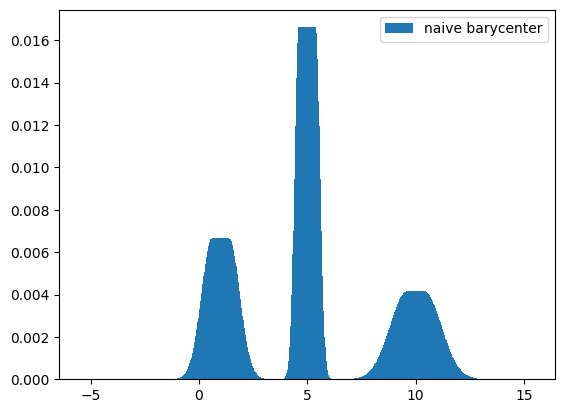

In [97]:
time_naive_0 = time.time()

coeffs = np.zeros(M)
for j in range(3):
    coeffs += norm.pdf(x, loc=means[j], scale=stds[j])
coeffs /= np.sum(coeffs)

time_naive_1 = time.time()

# plot barycenter 
plt.bar(x, coeffs, label='naive barycenter')
# plt.plot(t, norm.pdf(t, loc=means[0], scale=stds[0]), label='$\mu_1$')
# plt.plot(t, norm.pdf(t, loc=means[1], scale=stds[1]), label='$\mu_2$')
# plt.plot(t, norm.pdf(t, loc=means[2], scale=stds[2]), label='$\mu_3$')

plt.legend()

plt.show()

**Method 2:** Using regularized bregman method

Here, the input measures have to be discretized on the same grid as the target barycenter.

In [6]:
A = np.zeros((M, 3))
vmin = .02
for j in range(3):
    a = norm.pdf(x, loc=means[j], scale=stds[j])
    A[:, j] = normalize( a + a.max()*vmin)

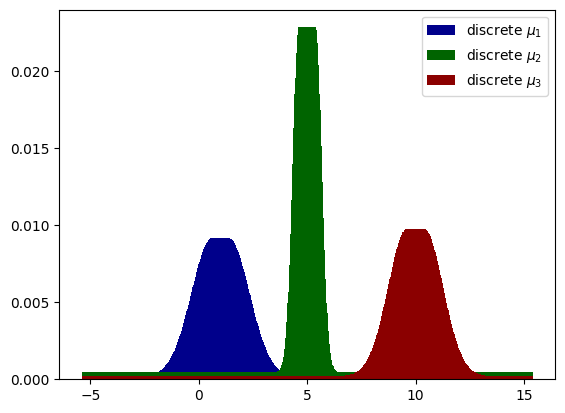

In [39]:
fig = plt.figure()

plt.bar(x, A[:, 0], label='discrete $\mu_1$', color = 'darkblue')
plt.bar(x, A[:, 1], label='discrete $\mu_2$', color = 'darkgreen')
plt.bar(x, A[:, 2], label='discrete $\mu_3$', color = 'darkred')
plt.legend()

plt.show()

In [41]:
# Bregman algo
# uniform weights
weights = np.ones(3) / 3

# Kernel 
epsilon = .05
[Y, X] = np.meshgrid(x, x)
K = np.exp(- (X - Y)**2/ epsilon )

# initialization 
v = np.ones((M, 3))
u = np.copy(v)

niter = 500
for i in tqdm(range(niter)):
    
    # update u
    for k in range(3): 
        u[:, k] = A[:, k] / np.dot(K, v[:, k])
    
    # compute barycenter
    b = np.zeros(M)
    for k in range(3):
        b += weights[k] * np.log( np.maximum(v[:, k] * np.dot(K, u[:, k]),
                                             1e-19*np.ones(M)))
    b = np.exp(b)

    # update v
    for k in range(3):
        v[:, k] = b / np.dot(K, u[:, k])
    

  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [00:00<00:00, 204.20it/s]


In [44]:
b = normalize(b)

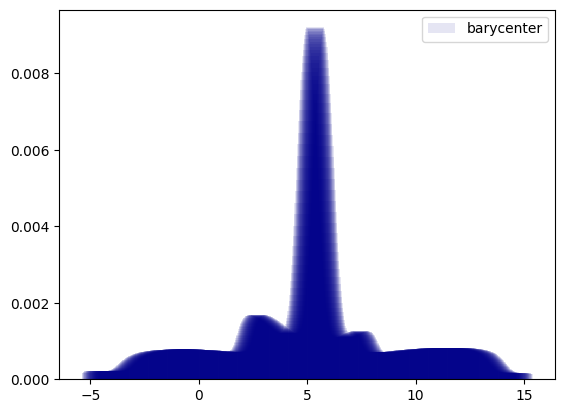

In [46]:
plt.bar(x, b, label='barycenter', color = 'darkblue')

plt.legend()
plt.show()

**Method 3:** Stochastic wasserstein barycenter without refined grid
$phi = {\phi_j^i}$
$C = d(x, y)^2 = ||x -y ||_2^2$ is the cost 

In [7]:
def sample_from_input_distribution(ind_j, n_samples : int = 10000):
    return norm.rvs(loc=means[ind_j], scale=stds[ind_j], size=(n_samples, 1))

In [8]:
x = x[:, np.newaxis] # (M, D)
x.shape

(500, 1)

In [ ]:
# [Y, X] = np.meshgrid(x, x)
# C = (X - Y)**2

In [ ]:
# 2D : plot Voronoi diagram 
# t = None
# [Y, X] = np.meshgrid(t, t)
# C = (X - Y)**2

In [9]:
# 1D 
def is_in_power_cell(y, ind_i: int, ind_j : int, phis, barycenter_point : np.ndarray):
    """
    y : (D)
    """
    assert -1 < ind_i < barycenter_point.shape[0]
    assert -1 < ind_j < phis.shape[0]

    c_values = ((y[np.newaxis, :]  - barycenter_point)**2).sum(-1) - phis[ind_j] # (M) 
    # print(c_values.min())
    return c_values[ind_i] == c_values.min()
    
def compute_value_a(ind_i: int, ind_j : int, phis, Y, barycenter_point : np.ndarray):
    """ using Monte Carlo method"""
    assert ind_i < phis.shape[1]
    assert ind_j < phis.shape[0]

    K = Y.shape[0]
    monte_carlo_sum = 0
    for y in Y:
        monte_carlo_sum += 1*is_in_power_cell(y, ind_i, ind_j, phis, barycenter_point)
    return monte_carlo_sum / K

def compute_value_b(ind_i : int, ind_j : int, phis, Y, barycenter_point : np.ndarray):
    """ using Monte Carlo method"""
    assert ind_i < phis.shape[1]
    assert ind_j < phis.shape[0]

    K = Y.shape[0]
    monte_carlo_sum = 0
    for y in Y:
        monte_carlo_sum += y*is_in_power_cell(y, ind_i, ind_j, phis, barycenter_point)
    return monte_carlo_sum / K  

def compute_gradient_phi_ij(ind_i: int, ind_j:int, phis, barycenter_point,
                         n_samples : int = 10000):

    Y = sample_from_input_distribution(ind_j, n_samples=n_samples)
    a_ij = compute_value_a(ind_i, ind_j, phis, Y, barycenter_point) # float
    
    N, M = phis.shape
    grad_f = (1/M - a_ij)/N
    return grad_f, a_ij

def compute_gradient_phi_j(ind_j : int, phis, barycenter_point,
                           n_samples : int = 10000):
    """ 
    Returns :
    grad_phi_j : array (M)
    a_j : array (M)
    """
    M = phis.shape[1]
    grad_phi_j = np.zeros(M)
    a_j = np.zeros(M)
    for i in range(M):
        grad_phi_j[i], a_j[i] = compute_gradient_phi_ij(i, ind_j, phis,
                                                barycenter_point,
                                                n_samples=n_samples)
    return grad_phi_j, a_j


In [10]:
n_samples = 10000 
nIter = 20
J = 3
D = 1
ascent_eps = 1e-4 # 1e-6
ascent_beta = .99
ascent_alpha = 1e-3

max_while_loop = 500

In [11]:
# Optimizing estimate of barycenter support 
time1 = time.time()
# initial potentials
phis = np.zeros((J, M))

for t in tqdm(range(nIter)):
    # ascent step 
    weight_a = np.zeros((J, M))
    for j in range(J):
        z_0 = np.zeros(M)
        w_0 = phis[j]
        grad_phi_j, _ = compute_gradient_phi_j(j, phis, x,
                                                 n_samples=n_samples)
        ascent_criteria = [np.linalg.norm(grad_phi_j, ord=1)]

        while ascent_criteria[-1] > ascent_eps:
            z_0 = ascent_beta*z_0 + grad_phi_j
            w_0 = w_0 + ascent_alpha*z_0
            grad_phi_j, a_j = compute_gradient_phi_j(j, phis, x,
                                                     n_samples=n_samples)
            ascent_criteria += [np.linalg.norm(grad_phi_j, ord=1)]

            if len(ascent_criteria) > max_while_loop:
                print('Warning : max_while_loop reached')
                break

        phis[j] = w_0
        weight_a[j] = a_j

    # snap step
    point_b = np.zeros((J, M, D)) # (J, M, D)
    for j in range(J):
        Y = sample_from_input_distribution(j, n_samples=n_samples)
        for i in range(M):
            point_b[j, i] = compute_value_b(i, j, phis, Y, x)
    weight_a = weight_a[:, :, np.newaxis] # (J, M, 1)
    
    for i in range(M):
        x[i] = np.sum(weight_a[:, i] * point_b[:, i], axis=0)
        x[i] /= np.sum(weight_a[:, i])

time2 = time.time()

  0%|          | 0/20 [00:00<?, ?it/s]

In [65]:
len(ascent_criteria)

215

In [69]:
a_j

array([0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   ,

In [70]:
np.linalg.norm(grad_phi_j)

0.033998365973806566

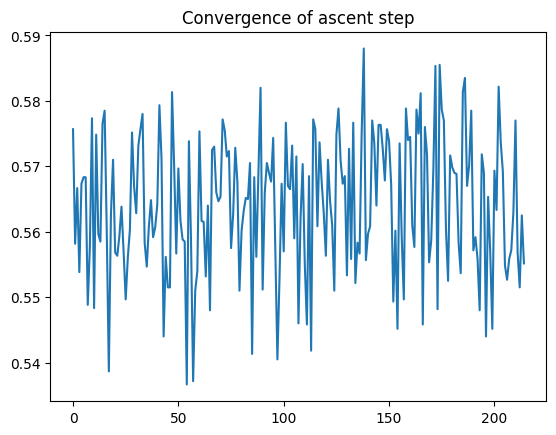

In [66]:
fig = plt.figure()

plt.plot(ascent_criteria)
plt.title('Convergence of ascent step')

plt.show()

In [6]:
# with OT 
import ot 

weights = np.ones(3) / 3

# wasserstein
reg = 1e-3
ot.tic()
bary_wass = ot.bregman.barycenter(A, M, reg, weights)
ot.toc()


# ot.tic()
# bary_wass2 = ot.lp.barycenter(A, M, weights)
# ot.toc()

print('Wass Barycenter with OT : ', bary_wass.shape)

plt.plot(x, bary_wass, label='POT Wass')

plt.legend()
plt.show()

ModuleNotFoundError: No module named 'ot'

## 1D Case : Dirac 

In [ ]:
a1 = np.zeros(M)
a2 = np.zeros(M)

a1[8] = .5
a1[10] = .5
a2[2] = .5
a2[4] = .5

print(a1.sum())

In [ ]:
plt.plot(x, a1, label='$\mu_1$')
plt.plot(x, a2, label='$\mu_2$')
plt.legend()
plt.show()